In [167]:
import datetime
import glob
import os
import random
import urllib
import zipfile

import boto3
import torch

from IPython.display import Image
import IPython.display as display
import ipywidgets as widgets

DATA = '../data'

# Setup

First, download and extract the labeled dataset.

In [186]:
data_bundle = DATA + '/traffic.zip'
s3_client = boto3.client('s3', endpoint_url='https://' + os.environ.get('S3_ENDPOINT_URL'), verify=False)
s3_client.list_buckets()

if not os.path.exists(data_bundle):
    !mkdir -p ../data;    
    s3_client.download_file(Filename=DATASET_ZIP, Bucket='traffic-detection-modeling', Key='traffic.zip')
    
with zipfile.ZipFile(data_bundle, 'r') as zip_ref:
    zip_ref.extractall(DATA)

# Inspect Environment

In [44]:
print('PyTorch Setup')
print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
print('')
print('YOLOv5 Version: %s' % yolov5.__version__)

PyTorch Setup
torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)

Yolov5 Version: 5.0.9


# Create Model Configuration

In [61]:
%%writefile ../data/yolov5l.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5categorica
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


Writing ../data/yolov5l.yaml


In [64]:
%%writefile ../data/hyps.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

Writing ../data/hyps.yaml


# Train YOLOv5

In [71]:
%%time
%cd ../data/
!yolov5 train --img 416 --batch 16 --epochs 100 --data 'data.yaml' --cfg yolov5l.yaml --hyp hyps.yaml --weights '' --name yolov5l_results --workers 1
%cd ../app/

/opt/app-root/src/traffic-patterns/data
train: weights=, cfg=yolov5l.yaml, data=data.yaml, hyp=hyps.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=1, project=runs/train, entity=None, name=yolov5l_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, mmdet_tags=False, neptune_token=, neptune_project=, freeze=0, img=416, batch=16
YOLOv5 🚀 2021-9-15 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate

# Inspect Results

Let's see how we did.

In [63]:
# find newest output directory
output_dir = DATA + '/runs/train/'
files = glob.glob(output_dir + '/*')
dirs = filter(os.path.isdir, files)
results_dir = max(dirs, key=os.path.getctime) + '/'
results_dir

'../data/runs/train/yolov5l_results5/'

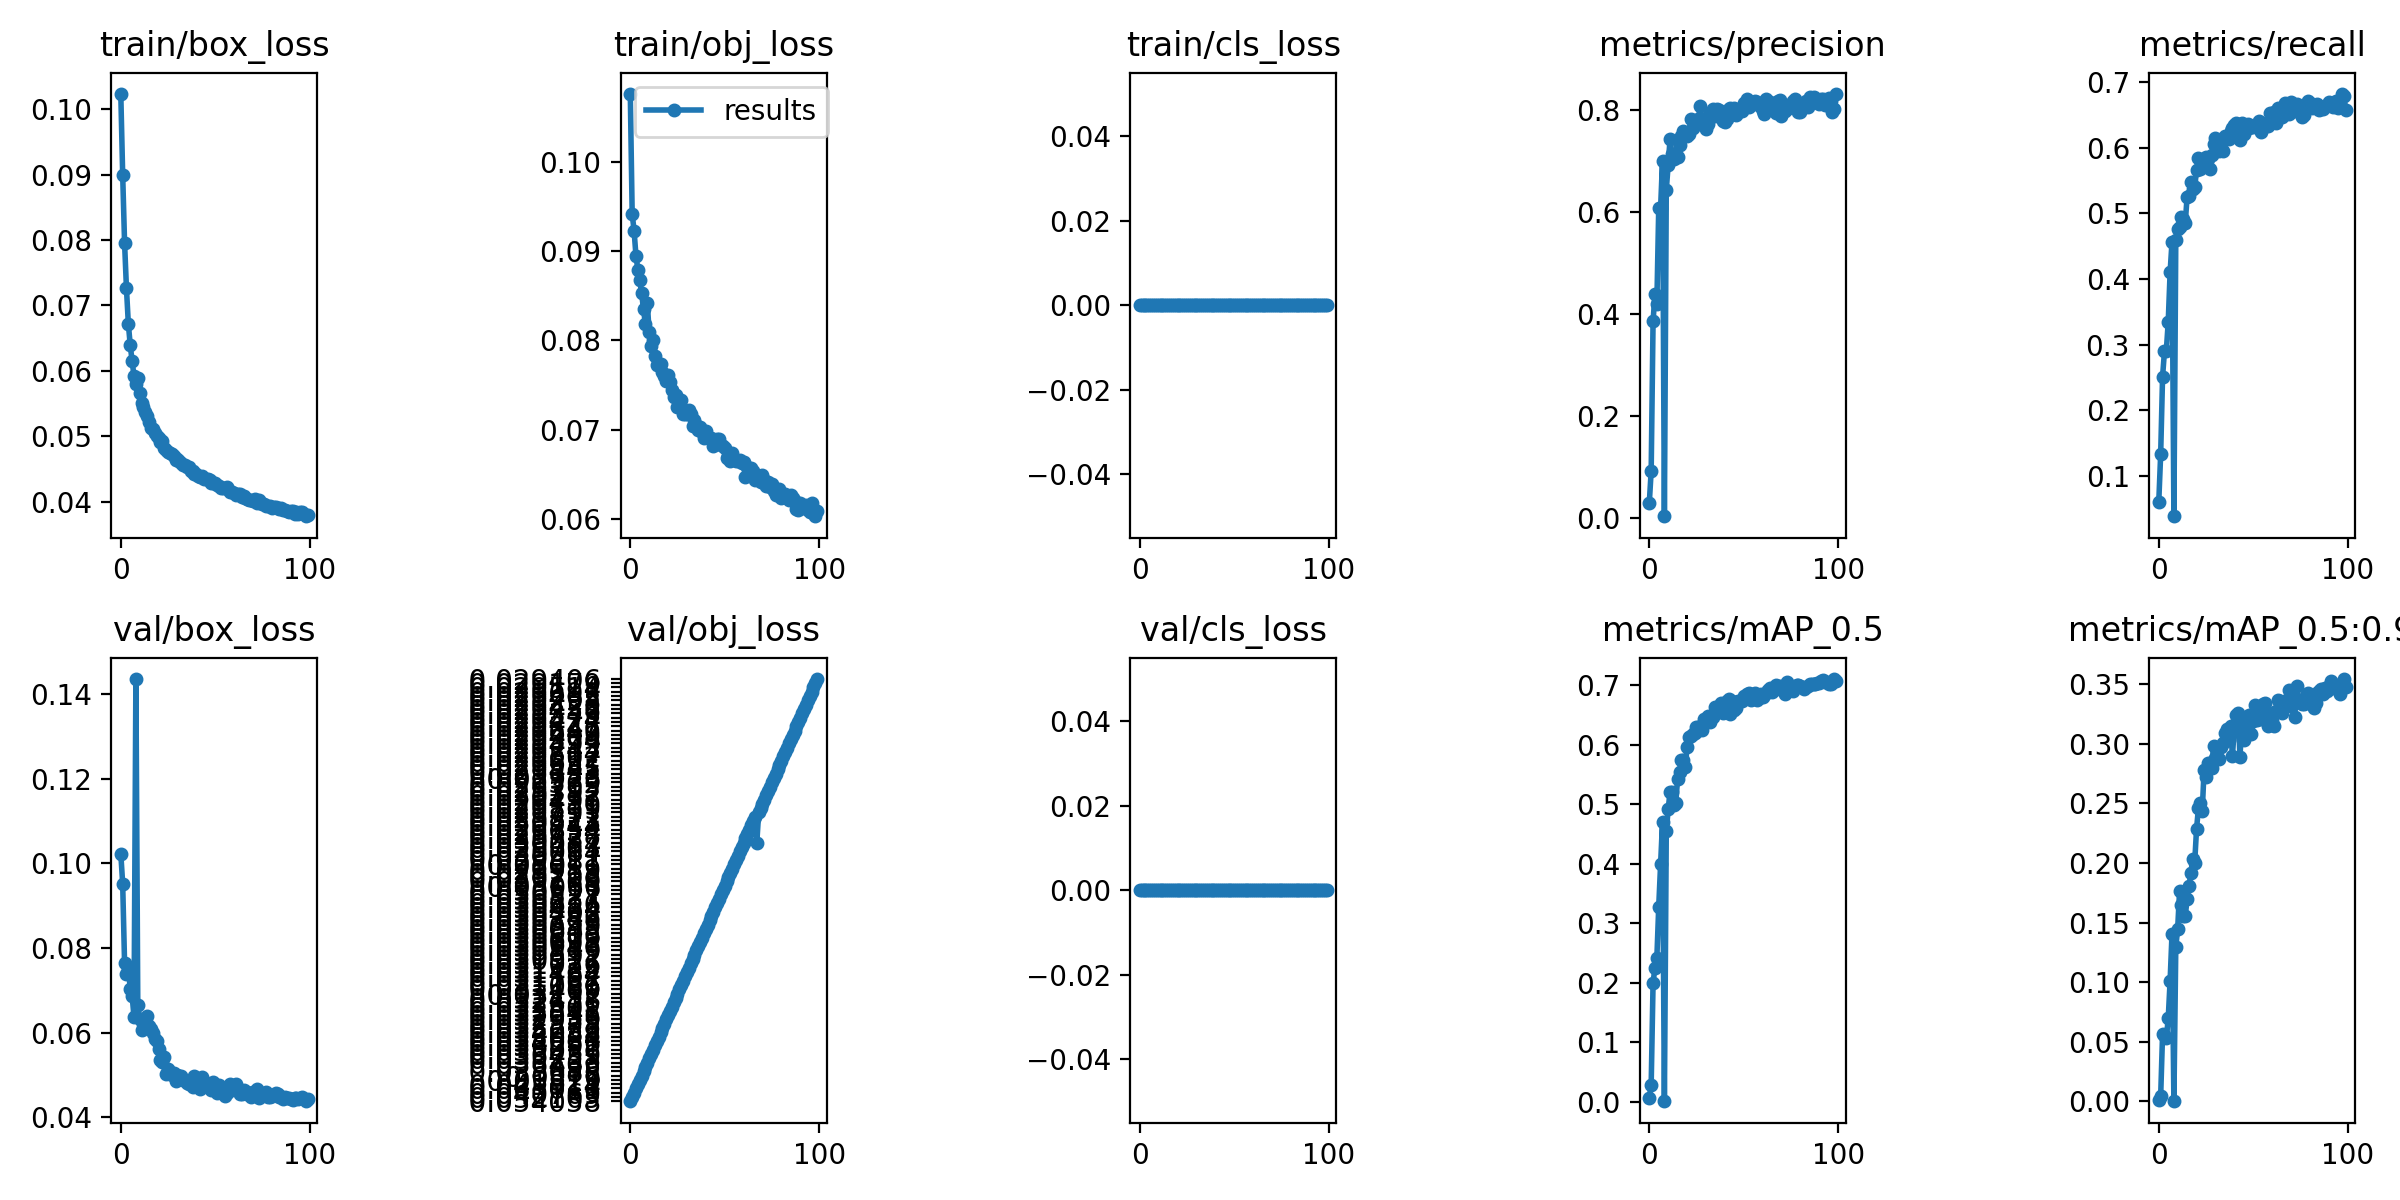

In [64]:
Image(results_dir + 'results.png')

Did we acheive convergence? Did we over-converge?

In [65]:
images = ['P_curve.png', 'R_curve.png']
boxes = []

for image in images:
    img = open(results_dir + image,'rb').read()
    wi = widgets.Image(value=img, format='jpg')
    boxes.append(wi)

output = widgets.HBox(boxes)
display.display(output)

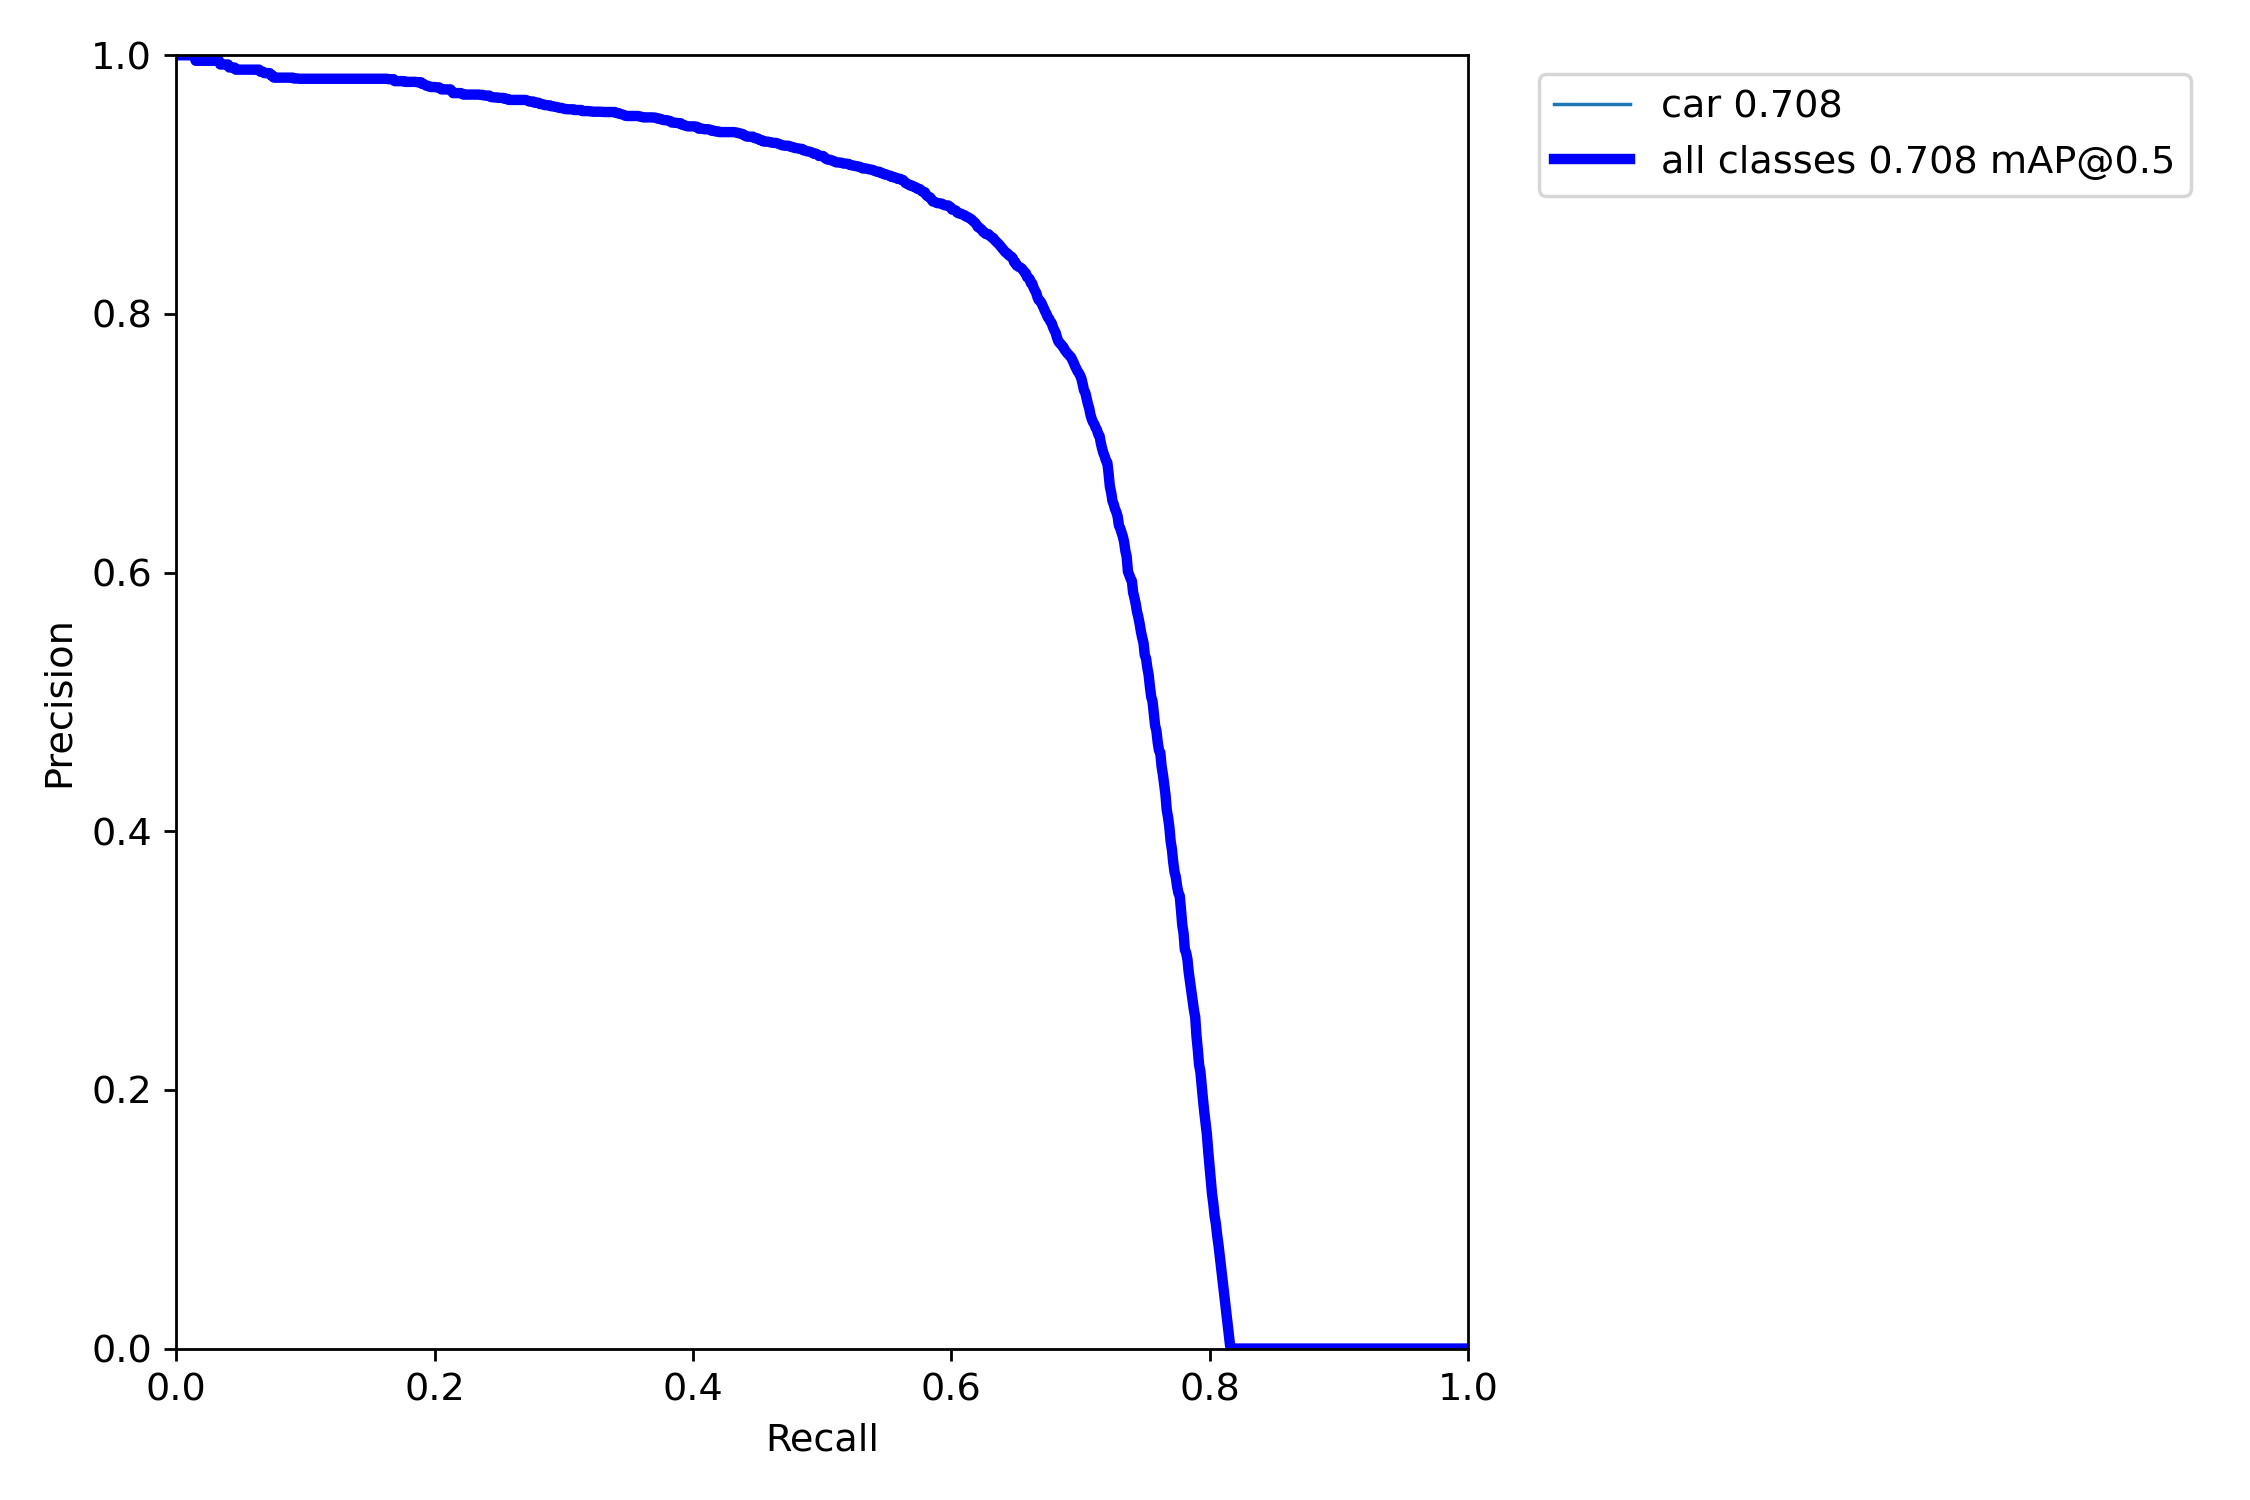

In [66]:
Image(results_dir + 'PR_curve.png')

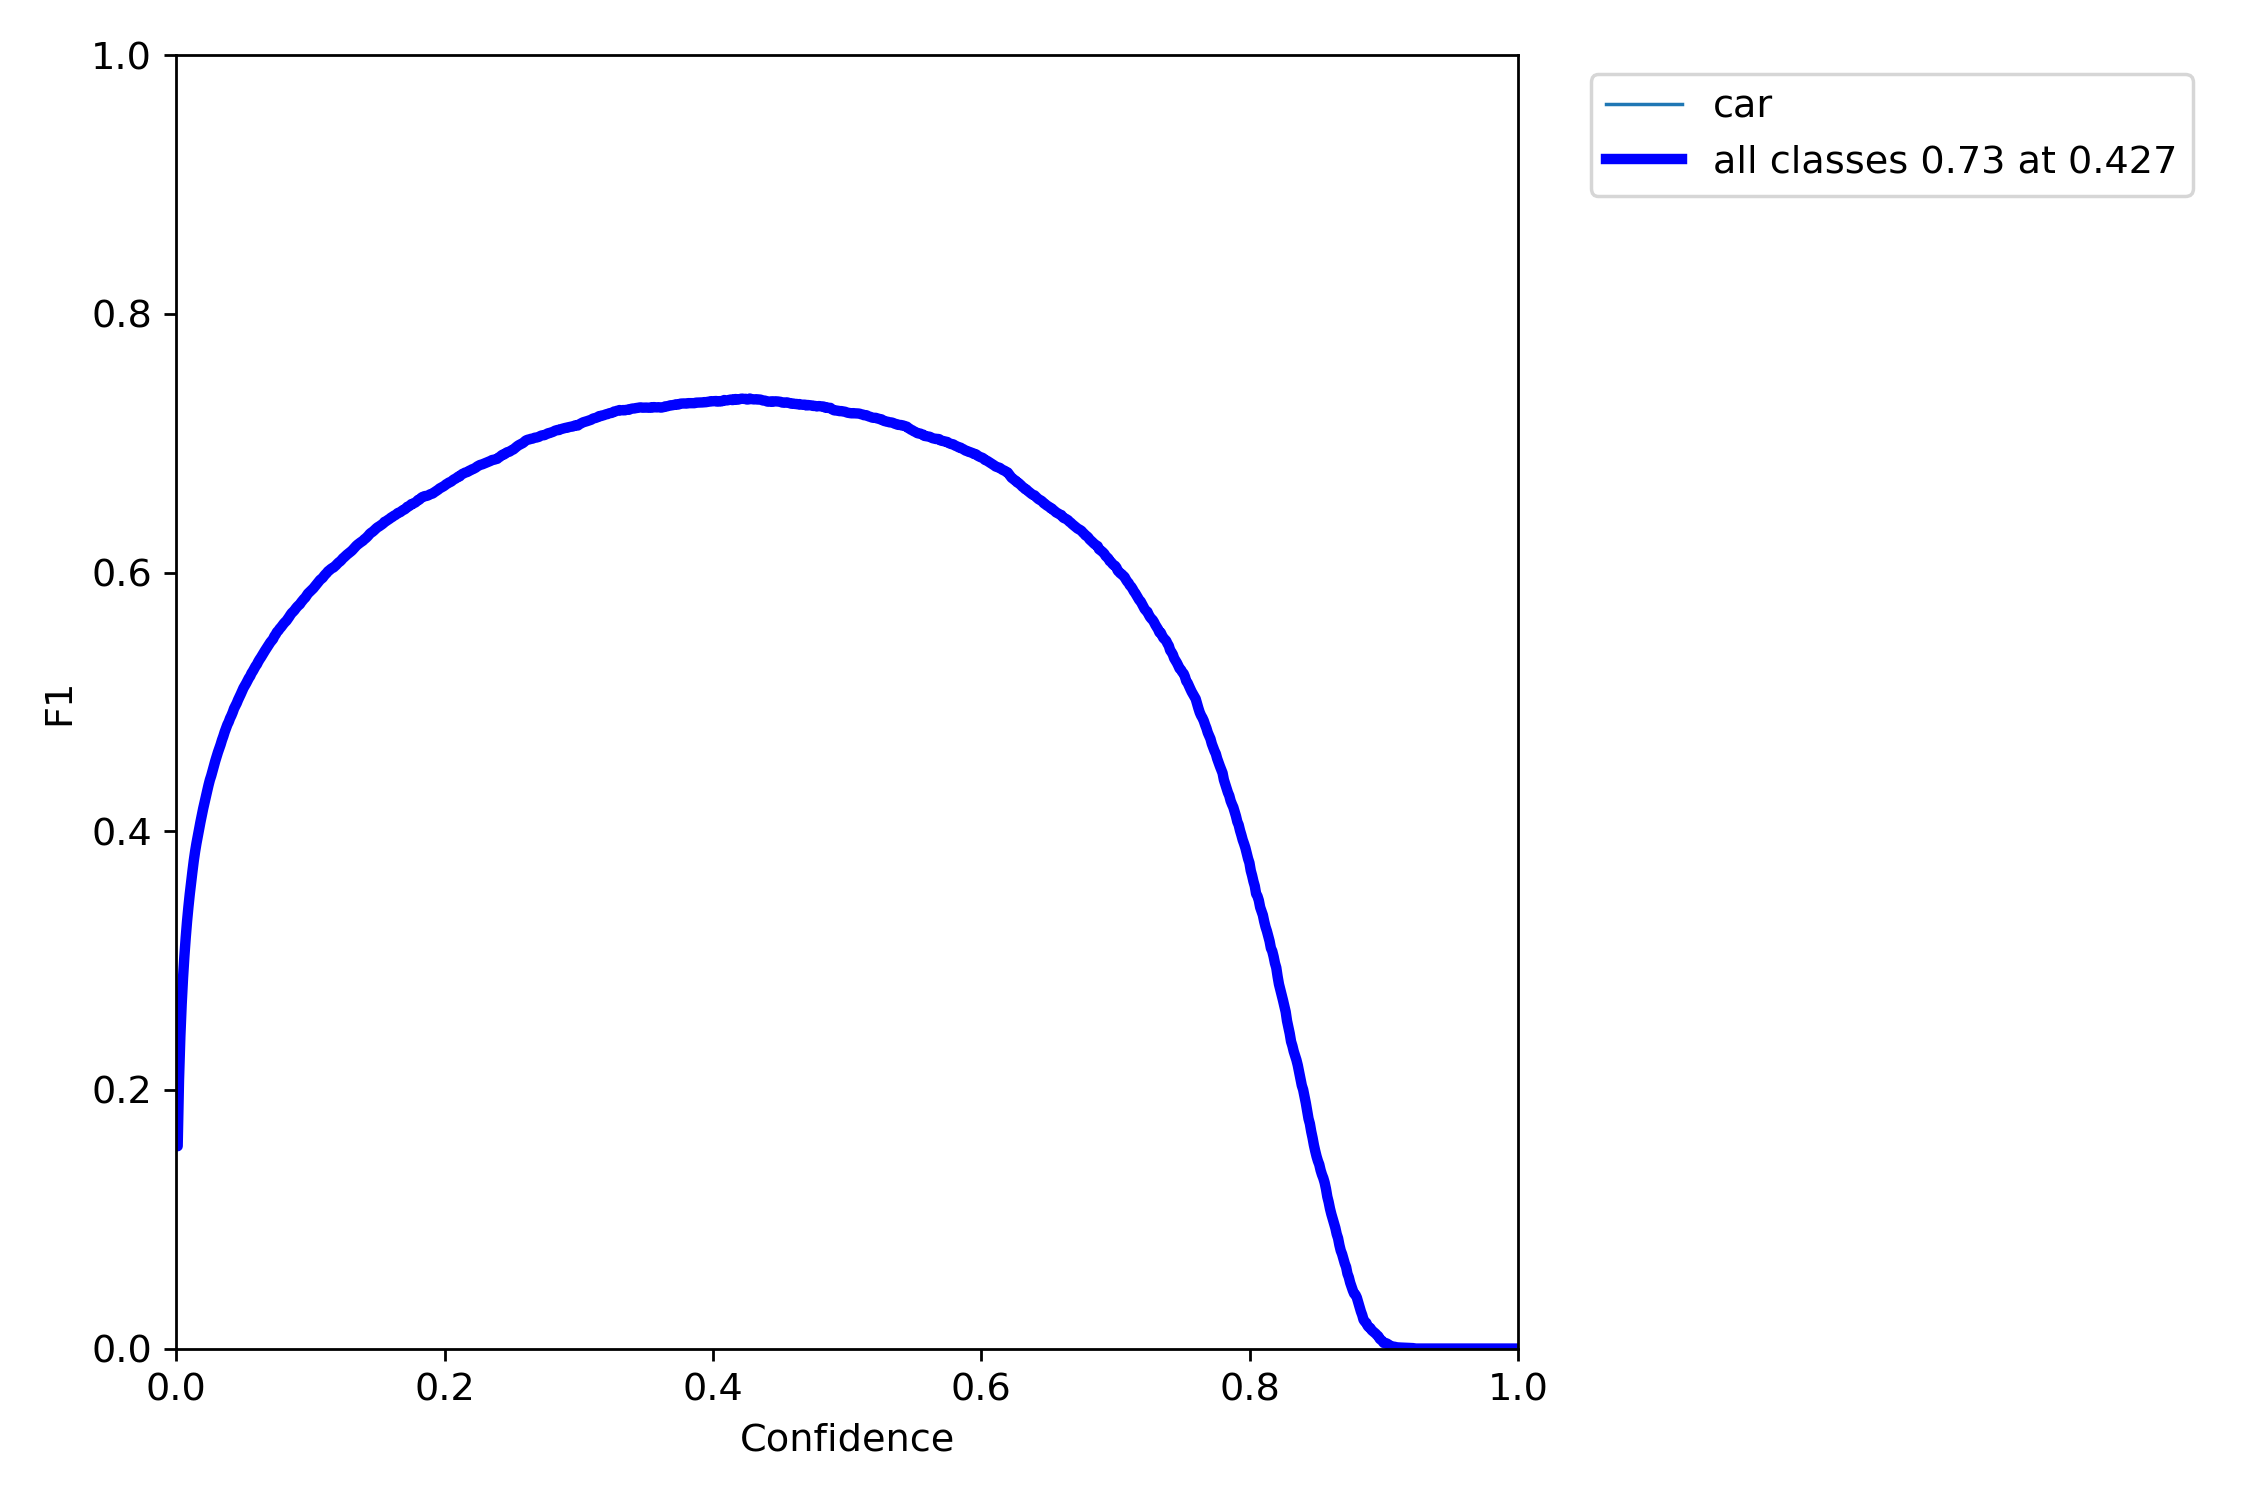

In [67]:
Image(results_dir + 'F1_curve.png')

Let's also take a look at some of the validation results.

In [68]:
images = ['val_batch0_', 'val_batch1_', 'val_batch2_']
label_layout = widgets.Layout(width='50%',height='30px')
vbox_layout = widgets.Layout(overflow_y='auto')
boxes = [widgets.HBox([widgets.Label('Labled', layout=label_layout), widgets.Label('Predicted', layout=label_layout)])]

for image in images:
    img1=open(results_dir + image + 'labels.jpg','rb').read()
    wi1 = widgets.Image(value=img1, format='jpg')
    img2=open(results_dir + image + 'pred.jpg','rb').read()
    wi2 = widgets.Image(value=img2, format='jpg')
    a=[wi1,wi2]
    boxes.append(widgets.HBox(a, layout=vbox_layout))

output = widgets.VBox(boxes, layout=vbox_layout)
display.display(output)

# Run Test Inferencing

In [ ]:
# What should the confidence threshold be?
conf_thres = 0.35

In [106]:
!yolov5 detect --weights $results_dir/weights/best.pt --imgsz 416,416 --conf_thres $conf_thres --source $DATA/test/images --project $DATA/runs/detect

YOLOv5 🚀 2021-9-15 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 392 layers, 46600566 parameters, 0 gradients, 114.1 GFLOPs
image 1/291 /opt/app-root/src/traffic-patterns/app/../data/test/images/Aptakisic-at-Brandywyn-East-2_jpg.rf.dc24529d185ab387b09ecaf26001160a.jpg: 416x416 6 cars, Done. (0.036s)
image 2/291 /opt/app-root/src/traffic-patterns/app/../data/test/images/Aptakisic-at-Brandywyn-West-3_jpg.rf.802c8ad567753d6f14dc44114459b1e6.jpg: 416x416 10 cars, Done. (0.036s)
image 3/291 /opt/app-root/src/traffic-patterns/app/../data/test/images/Aptakisic-at-Buffalo-Grove-North-4_jpg.rf.05b2d4fa5aad5a5127be2eb81f93e03e.jpg: 416x416 12 cars, Done. (0.036s)
image 4/291 /opt/app-root/src/traffic-patterns/app/../data/test/images/Aptakisic-at-Buffalo-Grove-West-6_jpg.rf.4ad70ccdafd270677a79aba596b44ab7.jpg: 416x416 5 cars, Done. (0.023s)
image 5/291 /opt/app-root/src/traffic-patterns/app/../data/test/images/Aptakisic-at-Leider-East-5_jpg.rf.a93947fdff200639

In [107]:
# find newest detect directory
detect_dir = DATA + '/runs/detect/'
files = glob.glob(detect_dir + '/*')
dirs = filter(os.path.isdir, files)
detect_results_dir = max(dirs, key=os.path.getctime) + '/'
detect_results_dir

'../data/runs/detect/exp3/'

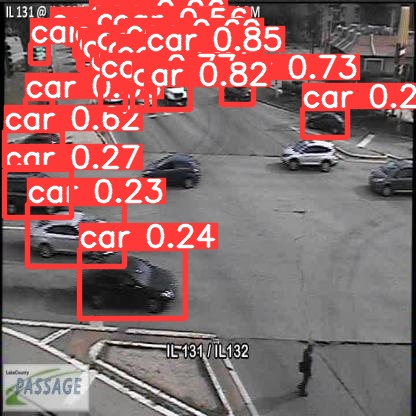

In [146]:
# display a random image
all_images = glob.glob(detect_results_dir + '/*.jpg')
Image(random.choice(all_images))

# Export Trained Weights

In [168]:
save_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
save_user = os.environ.get('JUPYTERHUB_USER', 'anonymous')
save_prefix = save_time + '-' + urllib.parse.quote(save_user)

In [184]:
!tar czf /tmp/$save_prefix-experiment.tgz $results_dir
!cp -a $results_dir/weights/best.pt /tmp/$save_prefix-weights.pt
!tar czf /tmp/$save_prefix-inputs.tgz ../data/hyps.yaml ../data/yolov5*.yaml $data_bundle

tar: Removing leading `../' from member names
tar: Removing leading `../' from member names
tar: Removing leading `../' from hard link targets


In [177]:
!ls -lah /tmp/$save_prefix*

-rw-r--r--. 1 1000670000 root       170M Sep 16 18:56 /tmp/20210916-184902-kube%3Aadmin-experiment.tgz
-rw-r--r--. 1 1000670000 root       153M Sep 16 18:56 /tmp/20210916-184902-kube%3Aadmin-inputs.tgz
-rw-rw-r--. 1 1000670000 1000670000  90M Sep 16 05:36 /tmp/20210916-184902-kube%3Aadmin-weights.pt


In [188]:
for fname in [f'{ save_prefix }-experiment.tgz', f'{ save_prefix }-weights.pt', f'{ save_prefix }-inputs.tgz']:
    print(fname)
    s3_client.upload_file(
        Filename=f'/tmp/{ fname }', 
        Bucket='traffic-detection-modeling', 
        Key=fname)

20210916-184902-kube%3Aadmin-experiment.tgz
20210916-184902-kube%3Aadmin-weights.pt
20210916-184902-kube%3Aadmin-inputs.tgz
